In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nn import (io, nn, preprocess)
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
positives = io.read_text_file("data/rap1-lieb-positives.txt")
negatives = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

In [3]:
"""
Because the negative sequences are longer than the positive sequences, I wrote a 
function in preprocess.py, trim_seqs, that randomly selects a consecutive sequence
of 17 nucleotides from each negative sequence.
"""

# trim negative sequences
trim_negatives = preprocess.trim_seqs(negatives, len(positives[0]))

In [4]:
"""
Because there are more negative than positive examples in this dataset, I use an 
upsampling scheme to increase the number of positive examples to match the number
of negative examples. In preprocess.py, the sample_seqs function samples from 
the positive (minority class) with replacement until there are the same number as the 
negative (majority class) samples. 
"""

# generate training set
all_seqs = np.asarray(positives + trim_negatives)
print(all_seqs.shape)
all_labels = np.asarray([True] * len(positives) + [False] * len(trim_negatives))
print(all_labels.shape)
(upsampled_seqs, upsampled_labels) = preprocess.sample_seqs(all_seqs, all_labels)
print(upsampled_seqs.shape)
print(upsampled_labels.shape)
X_train, X_test, y_train, y_test = train_test_split(upsampled_seqs, upsampled_labels,test_size=0.2, random_state=42)
y_train = y_train * 1
y_test = y_test * 1

# one hot encode sequences
X_train_encode = np.asarray(preprocess.one_hot_encode_seqs(X_train))
X_test_encode = np.asarray(preprocess.one_hot_encode_seqs(X_test))
print(X_train_encode.shape)
print(X_test_encode.shape)

(3300,)
(3300,)
number of samples in minority class: 137
number of samples in majority class: 3163
(6326,)
(6326,)
(5060, 68)
(1266, 68)


In [5]:
# train neural network
test_arch = [{'input_dim': 68, 'output_dim': 17, 'activation': 'sigmoid'}, {'input_dim': 17, 'output_dim': 68, 'activation': 'sigmoid'}, {'input_dim': 68, 'output_dim': 1, 'activation': 'sigmoid'}]

"""
Selection of hyperparamaters:
I selected the Binary Cross Entropy loss function because the network is using logistic
regression to separate the input into two classes: Rap1 binding site or non-binding site.
The other hyperparameters were selected through trial and error until I got acceptable
results.
"""

test_nn = nn.NeuralNetwork(nn_arch = test_arch, lr = 0.005, seed = 29, batch_size = 300, epochs = 50, loss_function = "bce")
(test_train_loss, test_val_loss) = test_nn.fit(X_train_encode.T, y_train, X_test_encode.T, y_test)

EPOCH: 1
[0.13858275 0.13919013 0.13839994 0.13975407 0.13971497 0.14078019
 0.13777788 0.13920828 0.14041307 0.13959196]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 2
[0.99962576 0.999628   0.99963721 0.9996299  0.99961975 0.99962564
 0.99962637 0.99962759 0.99963147 0.99962364]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 3
[0.0092676  0.00919178 0.0089206  0.00929585 0.00929546 0.00906697
 0.00885025 0.00915492 0.00925242 0.0091914 ]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 4
[0.99520204 0.99534148 0.99552138 0.99530098 0.99526781 0.9955749
 0.99551555 0.99536498 0.99540049 0.99538273]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 5
[0.04886652 0.04807815 0.04577833 0.04875771 0.0482118  0.04620222
 0.04498315 0.0476377  0.04807596 0.04770734]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 6
[0.94744489 0.94879337 0.95149706 0.94850227 0.94854032 0.9515943
 0.95177952 0.94921883 0.94966508 0.94944899]
[1 1 0 1 1 1 0 1 1 1]
EPOCH: 7
[0.09938002 0.09790741 0.0909534  0.09880548 0.09748961 0.09352954
 0.08931951 0.09673067 0.09717933 0.0970566 ]
[1 1 0 1 1 1 0 1

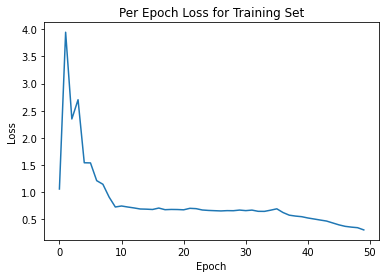

In [6]:
# plot losses
plt.figure()
plt.plot(test_train_loss)
plt.title("Per Epoch Loss for Training Set")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

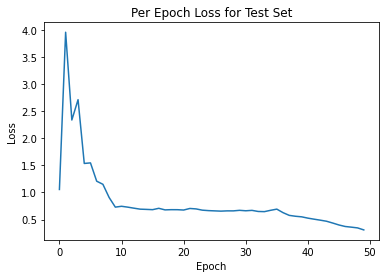

In [7]:
plt.figure()
plt.plot(test_val_loss)
plt.title("Per Epoch Loss for Test Set")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
# Evaluate
model_prob = test_nn.predict(X_test_encode.T)
model_pred = (model_prob >= 0.5) * 1
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, model_pred))
print('CLASSFICATION REPORT')
print(classification_report(y_test, model_pred))

CONFUSION MATRIX
[[556  79]
 [  0 631]]
CLASSFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       635
           1       0.89      1.00      0.94       631

    accuracy                           0.94      1266
   macro avg       0.94      0.94      0.94      1266
weighted avg       0.94      0.94      0.94      1266



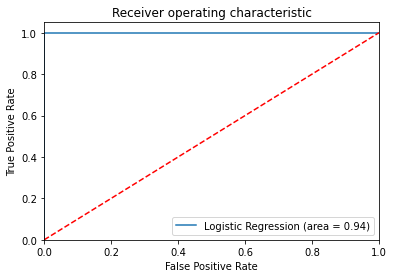

In [9]:
# ROC Curve
logit_roc_auc = roc_auc_score(y_test, model_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('TF_classifer_Log_ROC')
plt.show()